In [1]:
import os
import numpy as np
from numpy import array
import matplotlib
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# from mockfactory import Catalog
from cosmoprimo.fiducial import DESI
from desilike.theories.galaxy_clustering import DirectPowerSpectrumTemplate, ShapeFitPowerSpectrumTemplate, StandardPowerSpectrumTemplate
from desilike.theories.galaxy_clustering import KaiserTracerPowerSpectrumMultipoles, TNSTracerPowerSpectrumMultipoles, FOLPSTracerPowerSpectrumMultipoles
from desilike.observables.galaxy_clustering import TracerPowerSpectrumMultipolesObservable
from desilike.emulators import EmulatedCalculator, Emulator, TaylorEmulatorEngine
from desilike.samples import Profiles
from desilike.likelihoods import ObservablesGaussianLikelihood
from desilike import setup_logging
setup_logging()  # for logging messages

[Macpomme.local:07928] shmem: mmap: an error occurred while determining whether or not /var/folders/n0/gs1g7p590qg7trf8pp8w29ch0000gn/T//ompi.Macpomme.501/jf.0/187498496/sm_segment.Macpomme.501.b2d0000.0 could be created.


In [2]:
kmin     = 0.008
kmax     = 0.2
binning  = 0.006
k_ev     = np.arange(kmin, kmax+0.001, binning)
klim     = {ell*2: (kmin,kmax,binning) for ell in range(2)}

# the cosmology parameters
catalogue   = 'fiducial'  # fiducial, Mnu_p, Mnu_ppp -- QUIJOTE catalogue
cosmology   = 'LCDM'  # LCDM, nuCDM, nsFree, wCDM -- cosmology model
r_pk        = 'RSD'  # RSD, LRG, QSQ, CATAS-- systematics
CovRsf      = 25  # -- covariance rescale factor

In [3]:
def dataload(data):
    Pk0 = [[],[]]
    Pk2 = [[],[]]
    k = data[0,:,1]
    l0 = data[:,:,3]
    l2 = data[:,:,4]
    Pk0[0] = np.mean(l0,axis=0)
    Pk0[1] = np.std(l0,axis=0)
    Pk2[0] = np.mean(l2,axis=0)
    Pk2[1] = np.std(l2,axis=0)
    pk_cov = np.append(l0,l2,axis=1)
    cov = np.cov(np.array(pk_cov).T)
    # icov = np.linalg.inv(cov)
    return (k,Pk0,Pk2, cov)

def Pkload(catalogue, r_pk, redshift):
    # load the QUIJOTE observation
    tool = 'Pypower' # Powspec, Pypower, NCV
    Ddir = f'/Users/alain/Desktop/projectNU/main/data/kbin2/{catalogue}/{r_pk}_z{redshift}/pk'
    data = []
    nb = np.arange(100,200,1)
    for h in nb:
        realisation=np.loadtxt(Ddir+f'/{catalogue}_{h}_z{redshift}.pk')
        data.append(realisation)
    print(Ddir+f'/{catalogue}_{h}_z{redshift}.pk')
    (kev, pk0, pk2, icov) = dataload(np.array(data))
    pkl = [kev, pk0, pk2, icov]
    return pkl


In [4]:
model = 'FOLPS'
redshift= 1.0
emulator_fn = f'./model/emulator_{model}_z{redshift}.npy'
profile_fn = f'./profiler_result/profile_{model}_z{redshift}.npy'
if model == 'Kaiser':
    theory = KaiserTracerPowerSpectrumMultipoles(pt=EmulatedCalculator.load(emulator_fn))
elif model == 'TNS':
    theory = TNSTracerPowerSpectrumMultipoles(pt=EmulatedCalculator.load(emulator_fn))
elif model == 'FOLPS':
    theory = FOLPSTracerPowerSpectrumMultipoles(pt=EmulatedCalculator.load(emulator_fn))
profile = Profiles.load(profile_fn)
print(profile.to_stats(tablefmt='pretty'))
pkl_fiducial = theory(**profile.bestfit.choice(input=True))
[k_ev, pk0, pk2, cov] = Pkload('fiducial', 'RSD', redshift)
Pkobs = [pk0,pk2]


[000000.03] [0/1] 06-03 09:48  Emulator                  INFO     Loading ./model/emulator_FOLPS_z1.0.npy.
[000000.60] [0/1] 06-03 09:48  Profiles                  INFO     Loading ./profiler_result/profile_FOLPS_z1.0.npy.
+-------------------------------------+--------+---------+--------+
| chi2 / (66 - 11) = 0.30 / 55 = 0.01 | varied | bestfit | error  |
+-------------------------------------+--------+---------+--------+
|                  h                  |  True  |  0.673  | 0.062  |
|              omega_cdm              |  True  |  0.118  | 0.047  |
|               omega_b               |  True  | 0.02237 | 3.7e-4 |
|                logA                 |  True  |  3.10   |  0.77  |
|                 b1                  |  True  |   2.4   |  1.5   |
|                 b2                  |  True  |   -1    |   29   |
|                 bs                  |  True  |   -1    |   38   |
|               alpha0                |  True  |   -40   |  280   |
|               alpha2       

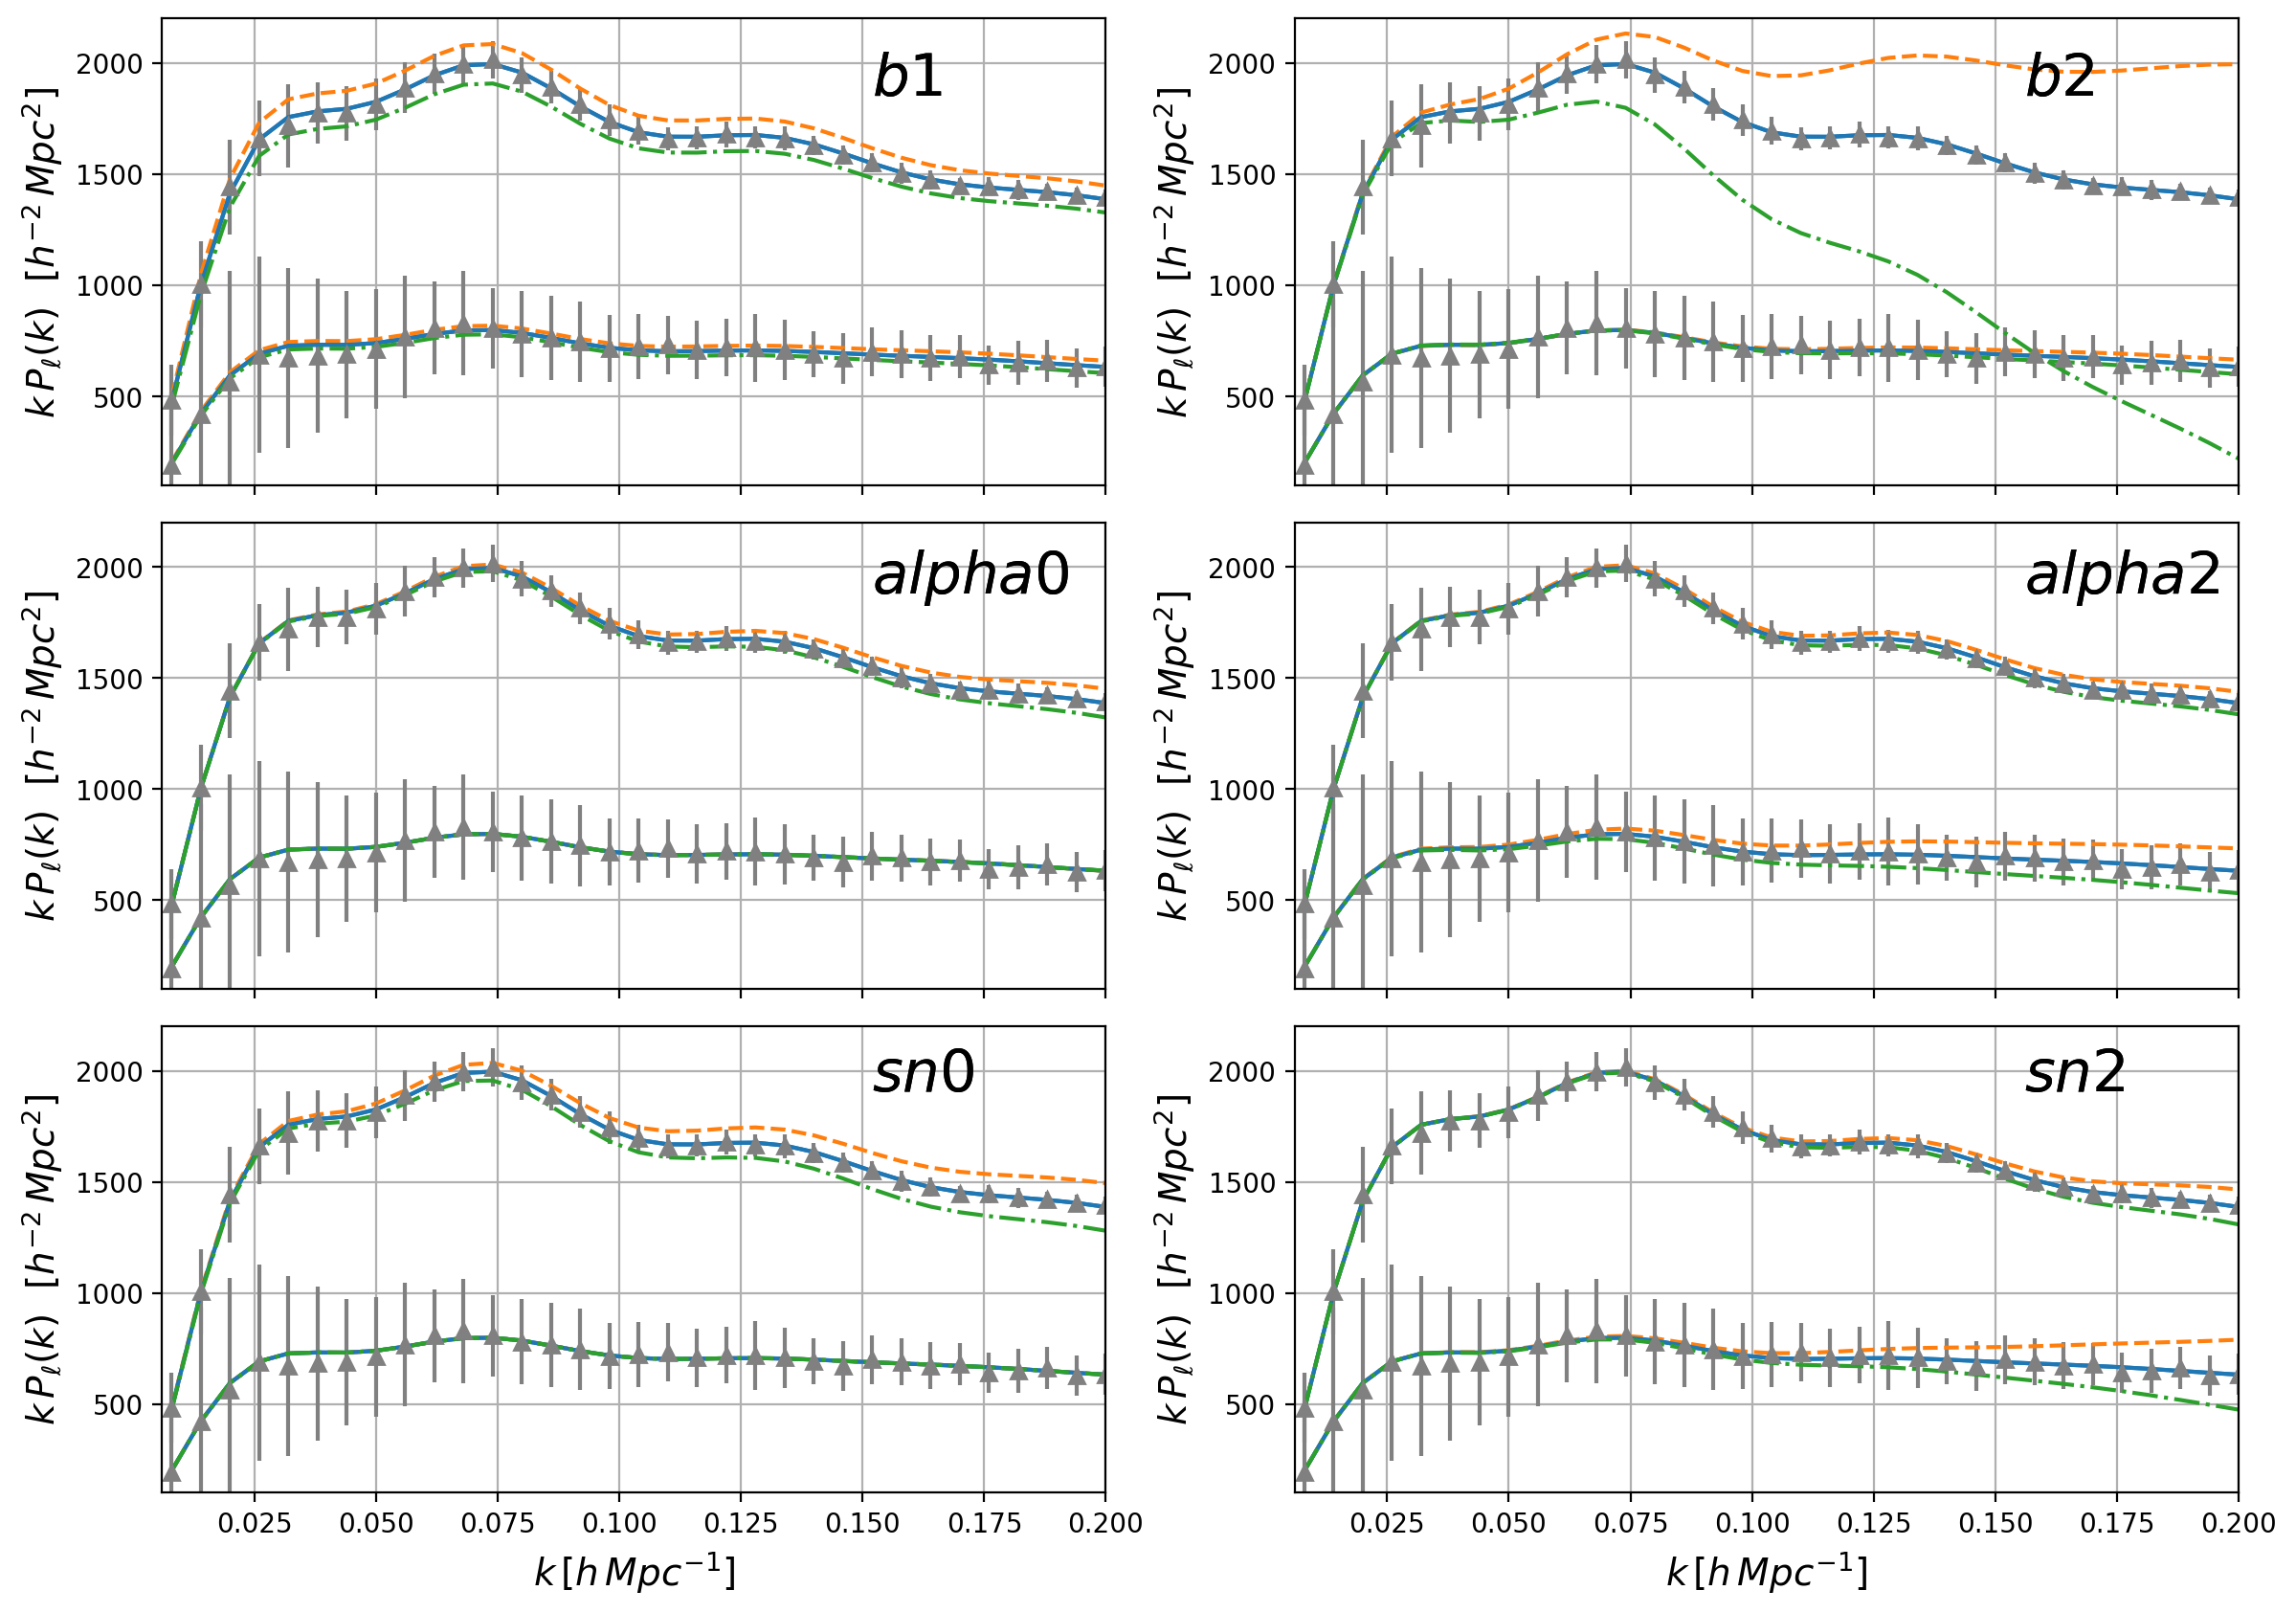

In [16]:
simga_h = 0.027; simga_oemga_cdm = 0.0075; simga_omega_b = 3.7e-4; sigma_logA = 0.069
simga_b1 = 0.064; simga_b2 = 3.4; simga_alpha0 = 11; simga_alpha2 = 26; simga_sn0 = 0.054; simga_sn2 = 3.0


cosmo_param = ['h','omega_cdm','omega_b','logA']
nuissance_param = ['b1', 'b2', 'alpha0','alpha2', 'sn0', 'sn2']
params = cosmo_param+nuissance_param
sigmas = {'b1':simga_b1, 'b2':simga_b2, 'alpha0':simga_alpha0,'alpha2':simga_alpha2, 'sn0':simga_sn0, 'sn2':simga_sn2}

lss = ['--', '-.']
colors = ['C1', 'C2']

# for modify_param in nuissance_param:
fig, axs = plt.subplots(3, 2, figsize = (14, 10),sharex=True)
fig.subplots_adjust(hspace=0.08)
for n,modify_param in enumerate(nuissance_param):
    x = int(n/2)
    y = n%2
    for i in range(2):
        bestfit = profile.bestfit.choice(input=True, params = params)
        # plt.figtext(0.3+y*0.43, 0.84-x*0.26, f'${modify_param} = {bestfit[modify_param]:.2f} \pm {sigmas[modify_param]:.2f}$', fontsize=15)
        plt.figtext(0.39+y*0.43, 0.84-x*0.26, f'${modify_param}$', fontsize=22)
        if i == 0:
            bestfit[modify_param] += sigmas[modify_param]
        elif i ==1:
            bestfit[modify_param] -= sigmas[modify_param] 
        pkl_modify = (theory(bestfit))

        for ell, l in zip(['monopole','quadrupole'],range(2)):
            if i ==0:
                axs[x][y].errorbar(k_ev, k_ev*Pkobs[l][0], k_ev*Pkobs[l][1], color = 'grey',fmt = '^')
            axs[x][y].plot(k_ev, k_ev*pkl_fiducial[l], color = 'C0')
            axs[x][y].plot(k_ev, k_ev*pkl_modify[l],  color =colors[i], ls = lss[i])
            plt.xlim([0.006, 0.2])
            axs[x][y].set_ylim([100, 2200])
    axs[x][y].grid(True)
    if x ==2:
        axs[x][y].set_xlabel(r'$k \, [h\, Mpc^{-1}]$', fontsize =  14)
    axs[x][y].set_ylabel(r'$k \, P_{\ell}(k)$  $[h^{-2} \, Mpc^{2}]$', fontsize =  14)
